# Project 2: The two-dimensional Ising model


The Ising model is described by the classical Hamiltonian

\begin{equation}
  \mathcal{H} = -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j
\end{equation}

where $\sigma_i=\pm1$ is an Ising spin on the site $i$ of a square
lattice and $J>0$ is a ferromagnetic coupling between nearest-neighbor
spins. The square lattice has $N = L \times L$ sites.

Onsager solved this problem analytically and showed that on the
infinite lattice ($N \rightarrow \infty$) there is a
phase transition at a temperature $T_c$ from a disordered state at high temperatures
to a magnetic state with finite magnetization $m \ne 0$ where

\begin{equation}
  \langle m \rangle = \lim_{N \rightarrow \infty}
     \frac{1}{N} \sum_{i=1}^N \langle \sigma_i \rangle
\end{equation}

The value of the critical temperature (we set $k_B=1$) is

\begin{equation}
  \frac{T_c}{J} = \frac{2}{\log (1 + \sqrt{2})} \simeq 2.27
\end{equation}

The goal of this project is to study the two-dimensional Ising model
using a Monte Carlo algorithm and see whether we can find evidences
for the phase transition even though we will be dealing with finite
systems.


Magnetization is kept zero

In [2]:
%matplotlib notebook
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
import time
import plotly.express as px

In [3]:
class Configuration:
    """A configuration of Ising spins"""

    def __init__(self, T, J, L):
        self.size = L
        self.J = J
        self.beta = 1./T
        self.spins = rnd.choice([-1,1], size=(L,L))      # either +1 or -1
        self.magnetization = self._get_magnetization()
        self._zero_magnetization()
        self.energy = self._get_energy()
#         self.total_magnetization = self.spins    # should be updated every cycle
        self.total_magnetization = np.zeros((L,L))
        self.number_of_cycles = 0
#         self.avg_magnetization = self.total_magnetization / self.number_of_cycles    # should be updated every cycle
        self.avg_magnetization = np.zeros((L,L), dtype = 'float64')
    
    def _zero_magnetization(self):
        L = self.size
#         print(self.magnetization)
        while self.magnetization > 0:
            i, j = rnd.randint(L), rnd.randint(L)
            if self.spins[i,j] > 0:
                self.spins[i,j] *= -1
                self.magnetization -= 2
        while self.magnetization < 0:
            i, j = rnd.randint(L), rnd.randint(L)
            if self.spins[i,j] < 0:
                self.spins[i,j] *= -1
                self.magnetization += 2
    def get_spins(self):
        return self.spins
        
    def _get_energy(self):
        """Returns the total energy"""
        energ = 0.
        L = self.size
        for i,j in itertools.product(range(self.size), repeat=2):
            energ += self.J[0] * self.spins[i,j] * (self.spins[(i + 1) % L, j] + \
                                                    self.spins[i ,(j + 1) % L] + \
                                                    self.spins[(i + 1) % L, (j + 1) % L])
            energ += self.J[1] * self.spins[i,j] * (self.spins[(i + 1) % L, (j - 1) % L] + \
                                                     self.spins[(i + 2) % L, (j + 1) % L] + \
                                                     self.spins[(i + 1)% L ,(j + 2) % L])
            energ += self.J[2] * self.spins[i,j] * (self.spins[(i + 2) % L, j] + \
                                                     self.spins[(i + 2) % L, (j + 2) % L] + \
                                                     self.spins[i ,(j + 2) % L])
        return energ
    
    def _get_magnetization(self):
        """Returns the total magnetization"""
        magnet = np.sum(self.spins)
        return magnet
    
    def pos(self, i, j):
        """Returns the postion in real space of the lattice point i,j"""
        L = self.size
        delta_x = (L - i - 1) * L / np.sqrt(3)
        x = j + delta_x
        y = i
        return np.array((x, y))
    
    def chi_real(self, r, i, j):
        """Returns the susceptibility in the real space
        i, j are the central i, j"""
#         s = self.avg_magnetization[i,j]
        s = self.avg_magnetization[i,j] * self.avg_magnetization[(i + r[0]), (j + r[1])]
        s -= 0    # average total magnetization is imposed to be zero
        return s
    
    def chi_momentum(self, q):
        """Return the susceptibility in the momentum space"""
        suma = 0
        L = self.size
        central = L // 2, L // 2
#         pos_0 = self.pos(0, 0)    # IN PROGRESS
        pos_0 = self.pos(central[0], central[1])
        for i in range(L):
            for j in range(L):
                r = self.pos(i,j) - pos_0
                s = self.chi_real((i, j), central[0], central[1])
                s *= np.exp(-1j * np.dot(q, r))
                suma += s
        return suma / L ** 2
    
def config_to_image(config):
    """Turn an array into an image"""
    L = config.size
    im = np.zeros([L,L,3])
    for i,j in itertools.product(range(L), repeat=2):
        im[i,j,:] = (1,0,0) if config.spins[i,j]==1 else (0,0,0)
    return im

def config_to_image_paral(config):
    """Turn an array into an image for triangular lattice
    in parallelogram shape"""
    L = config.size
    im = np.zeros([L,2 * L,3])
    for i,j in itertools.product(range(L), repeat=2):
#         im[i,j+L//2-i//2,:] = (1,0,0) if config.spins[i,j]==1 else (0,0,0)
        im[i,j - i + L - 1,:] = (1,0,0) if config.spins[i,j]==1 else (0,0,0)
    return im

def plot_real_space(a, s = 7):
    """Plots the array a in a read space"""
    for i in range(len(a)):
        delta_x = (len(a) - i - 1) / np.sqrt(3)
        x = np.arange(delta_x, len(a) + delta_x, dtype = np.float64)
        if x[-1] == len(a) + delta_x: x = x[0:-1]
        y1 = np.zeros(len(a)) + (len(a) - i - 1) * np.sqrt(3) / 2
        y2 = np.zeros(len(a)) + (len(a) - i - 1) * np.sqrt(3) / 2
        for j in range(len(a[i])):
            if a[i][j] == 1:
                y1[j] = np.nan
            else:
                y2[j] = np.nan
        plt.plot(x, y1, '.b', markersize = s)
        plt.plot(x, y2, '.r', markersize = s)
    plt.xlim(-1,len(a) * 3 / 2 + 1)
    plt.ylim(-1,len(a) * np.sqrt(3) / 2)
    plt.show()
            

<IPython.core.display.Javascript object>


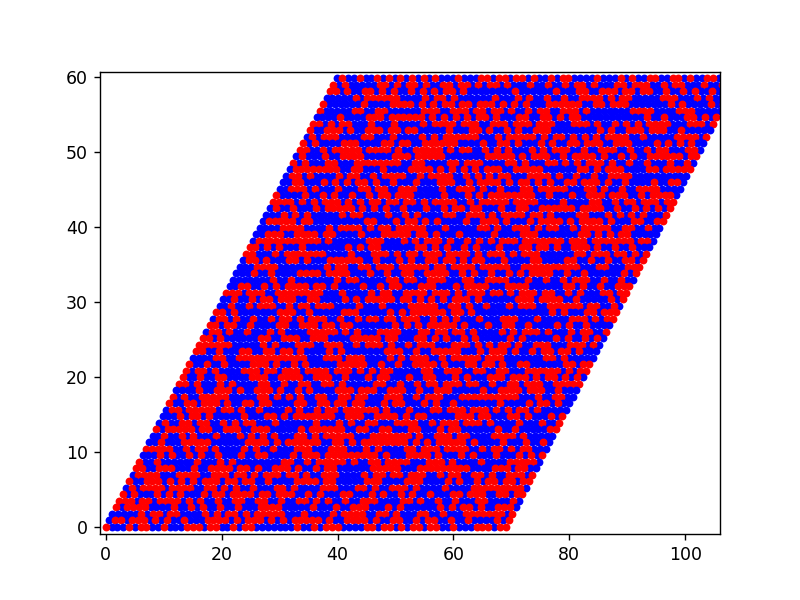

In [4]:
L = 70
a = np.random.choice([0, 1], size = (L,L))
plot_real_space(a)

In [5]:
# Show the random configuration
config = Configuration(4.0, [1.0,2,3], 16)
# plt.imshow(config_to_image(config), interpolation='none')
# plt.imshow(config_to_image_paral(config), interpolation='none')
print("M =", config.magnetization, " E =", config.energy)

M = 0  E = 164.0


In [6]:
def metropolis_move(config):
    """Modify (or not) a configuration with Metropolis algorithm"""
    
    L = config.size
    J1 = config.J[0]
    J2 = config.J[1]
    J3 = config.J[2]
    beta = config.beta
    i1, j1 = rnd.randint(L, size=(2)) # pick a random site
    i2, j2 = rnd.randint(L, size=(2))
    while config.spins[i1,j1] == config.spins[i2,j2]:
        i2, j2 = rnd.randint(L, size=(2))
    
    # compute energy difference
    coef11 = -2 * J1 * config.spins[i1,j1]
    coef21 = -2 * J2 * config.spins[i1,j1]
    coef31 = -2 * J3 * config.spins[i1,j1]
    coef12 = -2 * J1 * config.spins[i2,j2]
    coef22 = -2 * J2 * config.spins[i2,j2]
    coef32 = -2 * J3 * config.spins[i2,j2]
    delta_energy = 0
    # changing the energy if one spin is flipped
    delta_energy += coef11 * (config.spins[i1,(j1 + 1) % L] + config.spins[(i1 + 1) % L, j1] + \
                           config.spins[i1,(j1 - 1) % L] + config.spins[(i1 - 1) % L, j1] + \
                           config.spins[(i1 + 1) % L, (j1 + 1) % L] + config.spins[(i1 - 1) % L, (j1 - 1) % L])
    
    delta_energy += coef21 * (config.spins[(i1 + 1) % L,(j1 - 1) % L] + config.spins[(i1 + 2) % L, (j1 + 1) % L] + \
                           config.spins[(i1 + 1) % L,(j1 + 2) % L] + config.spins[(i1 - 1) % L, (j1 + 1) % L] + \
                           config.spins[(i1 - 2) % L, (j1 - 1) % L] + config.spins[(i1 - 1) % L, (j1 - 2) % L])
    
    delta_energy += coef31 * (config.spins[i1,(j1 + 2) % L] + config.spins[(i1 + 2) % L, j1] + \
                           config.spins[i1,(j1 - 2) % L] + config.spins[(i1 - 2) % L, j1] + \
                           config.spins[(i1 + 2) % L, (j1 + 2) % L] + config.spins[(i1 - 2) % L, (j1 - 2) % L])
    config.spins[i1, j1] *= -1 # flipping the spin
    # changing the energy if the other spin is flipped
    delta_energy += coef12 * (config.spins[i2,(j2 + 1) % L] + config.spins[(i2 + 1) % L, j2] + \
                           config.spins[i2,(j2 - 1) % L] + config.spins[(i2 - 1) % L, j2] + \
                           config.spins[(i2 + 1) % L, (j2 + 1) % L] + config.spins[(i2 - 1) % L, (j2 - 1) % L])
    
    delta_energy += coef22 * (config.spins[(i2 + 1) % L,(j2 - 1) % L] + config.spins[(i2 + 2) % L, (j2 + 1) % L] + \
                           config.spins[(i2 + 1) % L,(j2 + 2) % L] + config.spins[(i2 - 1) % L, (j2 + 1) % L] + \
                           config.spins[(i2 - 2) % L, (j2 - 1) % L] + config.spins[(i2 - 1) % L, (j2 - 2) % L])
    
    delta_energy += coef32 * (config.spins[i2,(j2 + 2) % L] + config.spins[(i2 + 2) % L, j2] + \
                           config.spins[i2,(j2 - 2) % L] + config.spins[(i2 - 2) % L, j2] + \
                           config.spins[(i2 + 2) % L, (j2 + 2) % L] + config.spins[(i2 - 2) % L, (j2 - 2) % L])
    config.spins[i1, j1] *= -1 # flipping back the spin
    
    
    # accept modification with Metropolis probability
    # if not accepted: leave configuration unchanged
    if rnd.random() < np.exp(-beta*delta_energy):
        config.spins[i1,j1] *= -1
        config.spins[i2,j2] *= -1
        config.energy += delta_energy
        config.magnetization += 2*config.spins[i1,j1]
        config.magnetization += 2*config.spins[i2,j2]

def global_update(config):
    """Does a global update every cycle"""
    L = config.size
    for i in range(L):
        for j in range(L):
            config.spins[i,j] *= -1
    config.magnetization *= -1
    config.energy *= -1

<IPython.core.display.Javascript object>


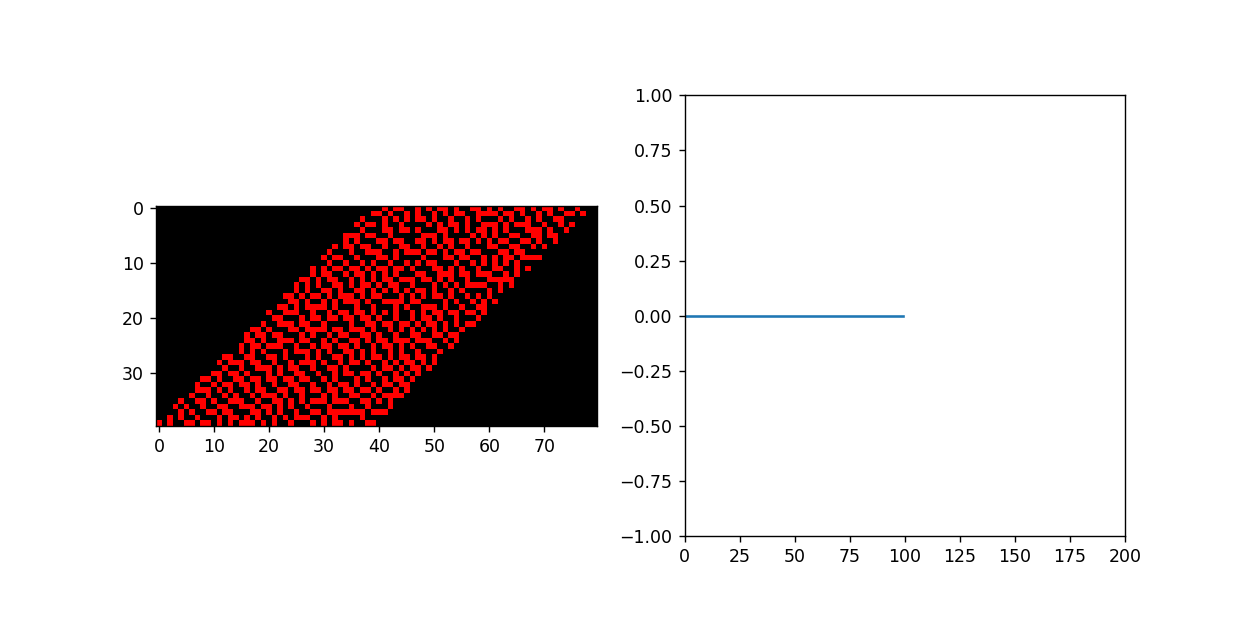

In [7]:
# make sure susceptibility converges
L = 40
T = 1.2
length_cycle = L*L
nt = 200
J = np.ndarray(3)
J[0], J[1], J[2] = 1, 0, 0
central = L // 2, L // 2

# instantiate a configuration
config = Configuration(T, J, L)

# a two-panel figure
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
im = ax1.imshow(config_to_image_paral(config), interpolation='none')
ax2 = fig.add_subplot(122, aspect=100)
line, = ax2.plot([],[])
ax2.set_xlim(0,nt)
ax2.set_ylim(-1,1)

steps = []
magnet = []

total_magnetization = np.zeros((L,L), dtype = 'float64')

def do_mc_cycle(n):
    
    for k in range(length_cycle):
        metropolis_move(config)
#     global_update(config)
    m = config.magnetization/float(config.size**2)
    im.set_array(config_to_image_paral(config))
    if len(steps) < nt: steps.append(n)
    if len(magnet) < nt:
        magnet.append(m)
    else:
        magnet.insert(nt, m)
        magnet.pop(0)

    line.set_data(steps, magnet)
    ###
#     config.total_magnetization += 1
#     config.total_magnetization += config.spins
#     total_magnetization += config.spin
#     sp = config.get_spins()
    for i in range(len(config.spins)):
        for j in range(len(config.spins)):
#             config.total_magnetization[i,j] += float(config.spins[i,j])    # IN PROGRESS
            config.total_magnetization[i,j] += float(config.spins[i,j]) * float(config.spins[central[0], central[1]])
#     total_magnetization += config.spins
    config.number_of_cycles += 1
    average_magnetization = total_magnetization / config.number_of_cycles
    config.avg_magnetization = config.total_magnetization / config.number_of_cycles
    ###
    return (im, line)

ani = animation.FuncAnimation(fig, do_mc_cycle, interval=1, blit=False)

<IPython.core.display.Javascript object>


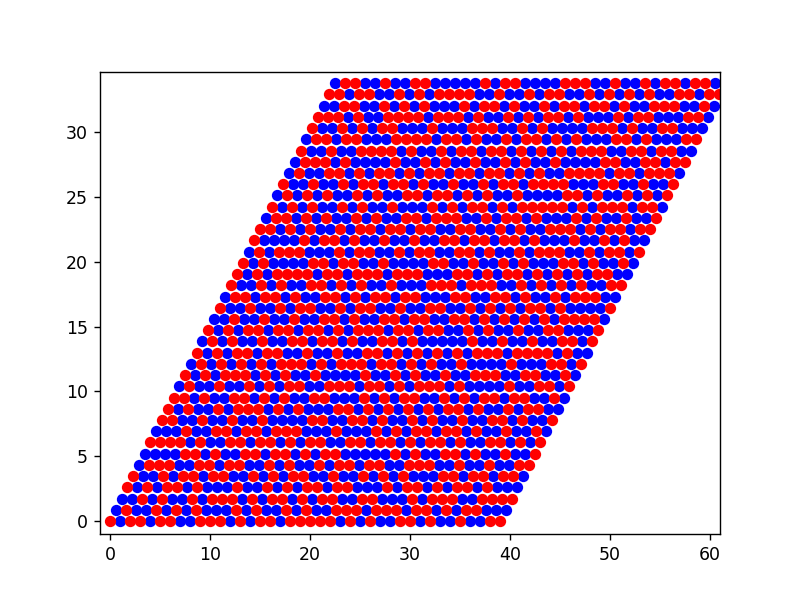

In [10]:
plot_real_space(config.spins, 11)

In [11]:
Nq = 40
# q = np.linspace(-np.pi, np.pi, Nq)
q = np.linspace(0, 2 * np.pi, Nq)
waveR = np.zeros((Nq, Nq))
waveIm = np.zeros((Nq, Nq))
for i in range(len(q)):
    for j in range(len(q)):
        waveR[i, j] = np.real(config.chi_momentum((q[i], q[j])))
        waveIm[i, j] = np.imag(config.chi_momentum((q[i], q[j])))
plt.plot(waveR)

IndexError: index 40 is out of bounds for axis 1 with size 40

In [64]:
px.imshow(waveR)
# px.imshow(waveIm)

<IPython.core.display.Javascript object>


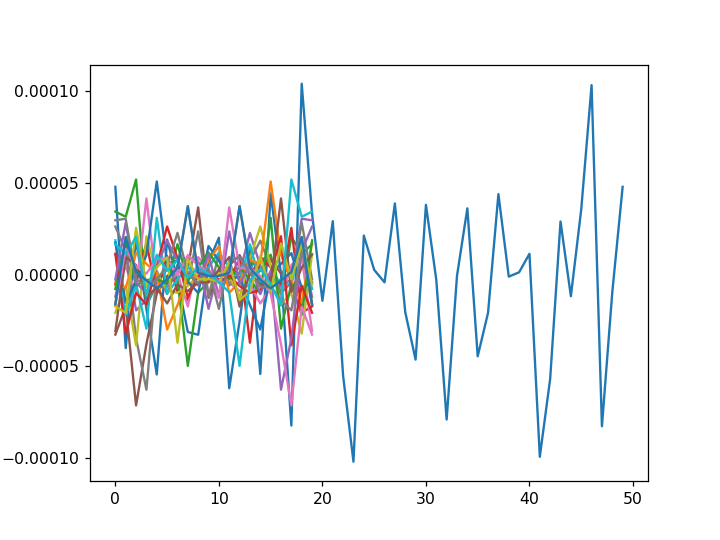

In [84]:
plt.plot(wave[0])

In [ ]:
config.spins
plot_real_space(config.spins)

In [ ]:
from tqdm.notebook import tqdm_notebook

# set temperature range
# temp_range = np.hstack([np.arange(0.5,2.,0.5), np.arange(2.,2.5,0.05), np.arange(2.5,5,0.5)])
temp_range = np.hstack([np.arange(2.8,4.6,0.1)])
temp_range = np.hstack([np.arange(1.6,25,1)])
mag = np.zeros_like(temp_range)
energ = np.zeros_like(temp_range)
chi = np.zeros_like(temp_range)
cv = np.zeros_like(temp_range)

# lattice size
L = 10
J = -1, 0, 0

pbar = tqdm_notebook(temp_range)
for i, T in enumerate(pbar):

    pbar.set_description(f"Processing T = {T:.2f}")

    config = Configuration(T, J, L)
    
    av_m, av_m2, av_e, av_e2 = 0,0,0,0

    n_cycles = 1000
    length_cycle = L*L
    n_warmup = 1000

    # Monte Carlo
    for n in range(n_warmup+n_cycles):
        
        for k in range(length_cycle):
            metropolis_move(config)
        
        if n >= n_warmup:
            av_e  += config.energy
            av_e2 += config.energy**2
            av_m  += np.abs(config.magnetization)
            av_m2 += config.magnetization**2
            
    # normalize averages
    av_m  /= float(n_cycles)
    av_m2 /= float(n_cycles)
    av_e  /= float(n_cycles)
    av_e2 /= float(n_cycles)
            
    # get physical quantities
    fact = 1./L**2
    mag[i] = fact * av_m
    energ[i] = fact * av_e
    cv[i] = fact * (av_e2 - av_e**2) / T**2
    chi[i] = fact * (av_m2 - av_m**2) / T    # Plot as a function of momentum
    
    # print info because progress can be slow
    #print("T = %f and %.2f percent done"%(T, (100.*(i+1))/len(temp_range)))


# save quantities in a file
np.savetxt("energ_%i.dat"%L, energ)
np.savetxt("mag_%i.dat"%L, mag)
np.savetxt("cv_%i.dat"%L, cv)
np.savetxt("chi_%i.dat"%L, chi)

In [ ]:
L = 10
Tc = 2./(np.log(1+np.sqrt(2)))
temp_range = np.hstack([np.arange(2.8,4.6,0.1)])
temp_range = np.hstack([np.arange(1.6,25,1)])

energ = np.loadtxt("energ_%i.dat"%L)
mag = np.loadtxt("mag_%i.dat"%L)
cv = np.loadtxt("cv_%i.dat"%L)
chi = np.loadtxt("chi_%i.dat"%L)
print(temp_range)

plt.plot(temp_range, np.loadtxt("energ_%i.dat"%L)+2, '-o', label="energy")
plt.plot(temp_range, np.abs(np.loadtxt("mag_%i.dat"%L)), '-o', label="magnetization")
plt.plot(temp_range, np.loadtxt("cv_%i.dat"%L), '-o', label="specific heat")
plt.plot(temp_range, np.loadtxt("chi_%i.dat"%L)/10, '-o', label="susceptibility")

# plt.plot([Tc,Tc], [0,1.6], '--', lw=3)
plt.legend()
plt.title("Physical quantities", fontsize=25)
plt.xlabel("$T$", fontsize=20)
plt.ylim(0,2)
plt.savefig('Physical quantities')

In [ ]:
L = 20
T = 2.0
J = 1, 0, 0

n_cycles = 500
length_cycle = L**2

# instantiate a configuration (J=1)
config = Configuration(T, J, L)

mr = np.zeros(n_cycles)
time = np.linspace(0, 1, n_cycles)

# Monte Carlo
for n in range(n_cycles):
    for k in range(length_cycle):
        metropolis_move(config)
    mr[n] = config.magnetization
mr /= float(L**2)
        
plt.plot(mr, time)
plt.title("Magnetization", fontsize=25)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("$m$", fontsize=20)
plt.ylim(-1,1)